
Source: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
# Copy into first cell
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Journey_to_PyTorchFastAI/"

# Switch to uploaded folder
import os
os.chdir('gdrive/My Drive/Journey_to_PyTorchFastAI/')

Mounted at /content/gdrive


In [0]:
from __future__ import print_function,division

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import time
import os
from copy import deepcopy
!pip install pkbar
import pkbar


In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
# data_dir = '/Users/Pike/Google Drive/Journey_to_PyTorchFastAI/data/flower_data_small/'
data_dir = root_dir + 'data/flower_data_small/'
print(data_dir)
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/content/gdrive/My Drive/Journey_to_PyTorchFastAI/data/flower_data_small/


In [6]:
device

device(type='cuda', index=0)

In [7]:
imgs,labels = next(iter(dataloaders['train']))
imgs.shape,labels

(torch.Size([64, 3, 224, 224]),
 tensor([6, 0, 9, 2, 4, 3, 1, 3, 9, 4, 9, 3, 2, 8, 5, 2, 1, 6, 8, 8, 1, 1, 1, 6,
         4, 6, 4, 9, 2, 4, 3, 3, 7, 6, 4, 4, 7, 8, 1, 7, 6, 6, 7, 4, 9, 6, 8, 7,
         1, 7, 4, 1, 1, 1, 3, 5, 9, 8, 9, 5, 9, 6, 0, 6]))

In [8]:
labels.data,labels

(tensor([6, 0, 9, 2, 4, 3, 1, 3, 9, 4, 9, 3, 2, 8, 5, 2, 1, 6, 8, 8, 1, 1, 1, 6,
         4, 6, 4, 9, 2, 4, 3, 3, 7, 6, 4, 4, 7, 8, 1, 7, 6, 6, 7, 4, 9, 6, 8, 7,
         1, 7, 4, 1, 1, 1, 3, 5, 9, 8, 9, 5, 9, 6, 0, 6]),
 tensor([6, 0, 9, 2, 4, 3, 1, 3, 9, 4, 9, 3, 2, 8, 5, 2, 1, 6, 8, 8, 1, 1, 1, 6,
         4, 6, 4, 9, 2, 4, 3, 3, 7, 6, 4, 4, 7, 8, 1, 7, 6, 6, 7, 4, 9, 6, 8, 7,
         1, 7, 4, 1, 1, 1, 3, 5, 9, 8, 9, 5, 9, 6, 0, 6]))

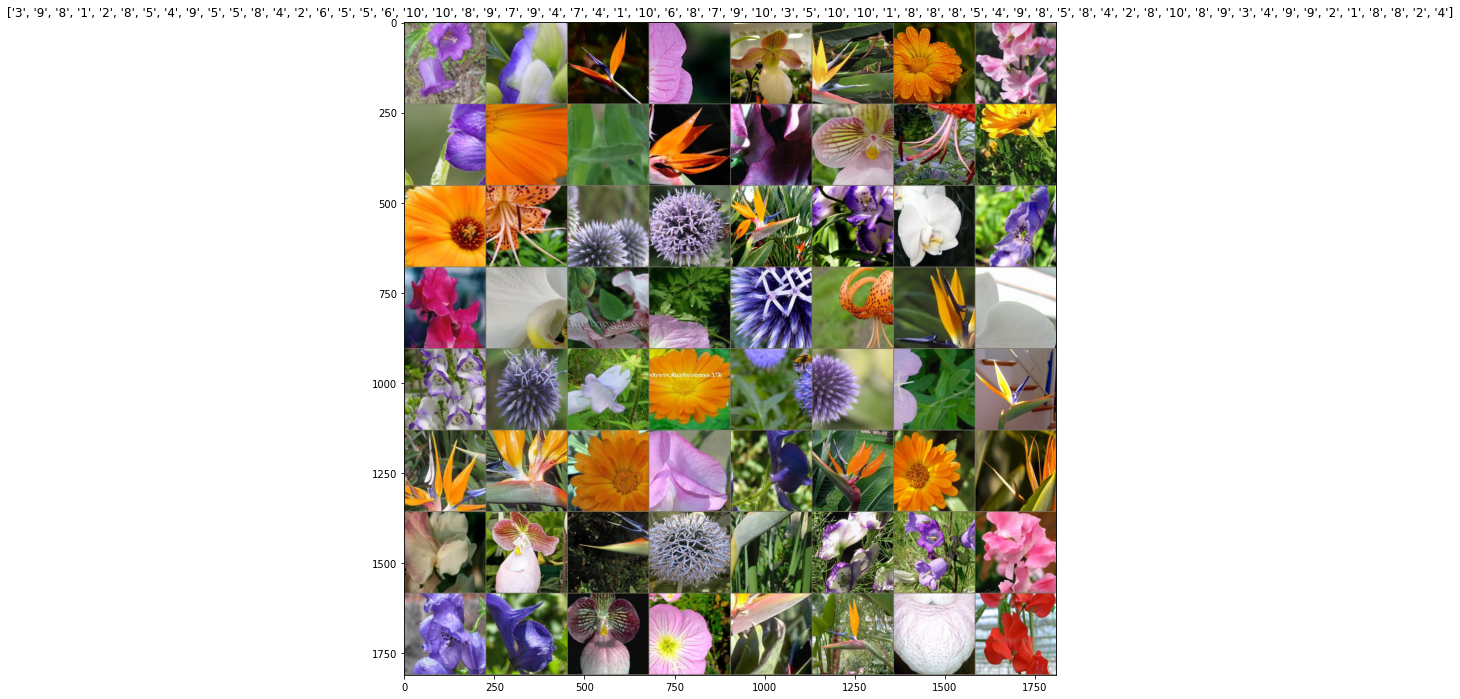

In [9]:
def imshow(inp, title = None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    inp = std *inp + mean
    inp = np.clip(inp,0,1)
    plt.figure(figsize=(12,12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
imgs,labels = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(imgs)
imshow(out,title=[class_names[x] for x in labels])


In [10]:
dataloaders['train']

In [11]:
image_datasets['train'].classes

['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']

In [0]:
def train_model(model, creiterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('_' * 10)
        
        for phase in ['train','valid']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            done_loader = 0.0
            pbar = pkbar.Pbar(name='Percentage of loading done', target= 100)
            # pbar_valid = pkbar.Pbar(name='Percentage Epoch done', target= len(dataloaders['valid']))

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # if phase == 'train':
                pbar.update(np.floor(100*(done_loader+1)/len(dataloaders[phase]))-1)
                done_loader += 1.


            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects.double()/dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))
            print()

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())

        print()
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model




In [0]:
model_ft = models.resnet18(pretrained=True)

In [14]:
len(dataloaders['valid'])

1

In [0]:
# from torchsummary import summary
# summary(model_ft,(3,224,224))

In [16]:
model_ft.fc = nn.Linear(model_ft.fc.in_features,len(class_names))
model_ft.fc

Linear(in_features=512, out_features=10, bias=True)

In [0]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

In [0]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 3e-3, momentum = 0.9)

exp_lr_schedule = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma = 0.1)

In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_schedule,num_epochs=2)

Epoch 0/1
__________
Percentage of loading done
100/100  [==============================] - 6.6s
train Loss: 2.2016 Acc: 0.2131

Percentage of loading done
100/100  [==============================] - 0.6s
valid Loss: 1.6039 Acc: 0.5116


Epoch 1/1
__________
Percentage of loading done
100/100  [==============================] - 6.6s
train Loss: 1.2091 Acc: 0.6651

Percentage of loading done
100/100  [==============================] - 0.6s
valid Loss: 0.6648 Acc: 0.8372




In [0]:
# To save the weight
torch.save(model_ft.state_dict(), 'myflower_classificationweights.pt')
# To save the complete model
torch.save(model_ft,'myflower_classification_model.pt')


# Only last layer train

In [0]:
model_ft1 = torchvision.models.resnet18(pretrained=True)
for params in model_ft1.parameters():
  params.requires_grad = False


In [0]:
model_ft1.fc = nn.Linear(model_ft1.fc.in_features,len(class_names))
model_ft1.fc
model_ft1.to(device);

In [0]:
from torchsummary import summary

In [25]:
summary(model_ft1,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [26]:
model_ft1.fc.parameters()

<generator object Module.parameters at 0x7f64547787d8>

In [0]:
optimizer_ft1 = optim.SGD(model_ft1.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft1, step_size=7, gamma=0.1)


In [28]:
model_conv = train_model(model_ft1, criterion, optimizer_ft1,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
__________
Percentage of loading done
100/100  [==============================] - 5.1s
train Loss: 2.4908 Acc: 0.1288

Percentage of loading done
100/100  [==============================] - 0.6s
valid Loss: 2.2006 Acc: 0.1860


Epoch 1/9
__________
Percentage of loading done
100/100  [==============================] - 5.1s
train Loss: 2.2146 Acc: 0.1827

Percentage of loading done
100/100  [==============================] - 0.6s
valid Loss: 1.9828 Acc: 0.3256


Epoch 2/9
__________
Percentage of loading done
100/100  [==============================] - 4.8s
train Loss: 1.8970 Acc: 0.4028

Percentage of loading done
100/100  [==============================] - 0.6s
valid Loss: 1.6300 Acc: 0.6279


Epoch 3/9
__________
Percentage of loading done
100/100  [==============================] - 4.8s
train Loss: 1.5908 Acc: 0.6206

Percentage of loading done
100/100  [==============================] - 0.6s
valid Loss: 1.3181 Acc: 0.7442


Epoch 4/9
__________
Percentage of loading done
